### UNCOVERING PATTERNS IN STACK EXCHANGE DATA - PART 1 - TOPIC MODELING

Arlene D’costa aadcosta@syr.edu

Samyuktha Chaparla schaparl@syr.edu

Sohan Thakur sothakur@syr.edu

Krunal Gaikwad kgaikwad@syr.edu

In [1]:
import pdb
from nltk.corpus import stopwords, twitter_samples
import numpy as np
import pandas as pd
import nltk
import string
import os
from nltk.tokenize import TweetTokenizer
from os import getcwd
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import json
import re
from nltk.corpus import wordnet
from collections import Counter
cnt = Counter()
import importlib
from nltk.corpus import words
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import sys

In [2]:
pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 30.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 23.2 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 8.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (7

In [55]:
path =  "/content/drive/MyDrive/SMDM"

In [3]:
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [5]:
sys.path.insert(0, f'{path}')

Usage of Technical Corpus for only filtering and retaining technical words

In [6]:
import technicalcorpus

In [7]:
test = importlib.reload(technicalcorpus)

In [8]:
english_words = set(words.words())
english_words = english_words.union(test.technical_terms)

In [9]:
STOPWORDS = set(stopwords.words('english'))

In [10]:
#Convert to lower
PUNCT_TO_REMOVE = string.punctuation

def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return "  ".join([word for word in str(text).split() if word not in STOPWORDS])


def filter_non_english_words(text):
    words_list = text.split()
    english_words_list = [word for word in words_list if word.lower() in english_words]
    return ' '.join(english_words_list)

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

In [11]:

def remove_urls_punct(text):
        url_pattern = re.compile(r'https?://\S+|www\.\S+')
        url_new = re.compile(r'<.*?>')
        url_punc = re.compile(r",|'|#|\$|&|^|\.|!")
        text = url_pattern.sub(r' ', text)
        text = url_punc.sub(r' ', text)
        return url_new.sub(r' ', text)


DATA CHECKS AND PREPROCESSING

In [56]:
postdf = pd.read_csv(f'{path}/post1.csv')
postdf = postdf.rename(columns=lambda x: x.replace('Attribute:', '') if x.startswith('Attribute:') else x)
postdf = postdf.rename(columns=lambda x: x.replace('_', '') if x.startswith('_') else x)

SELECTING ROWS WHERE THE POSTS HAVE BEEN CREATED AFTER 2020

In [57]:
postdf['CreationDate'] = postdf['CreationDate'].str.replace('<em>', '').str.replace('</em>', '')

# Convert to datetime format, with errors='coerce' to handle unparseable dates
postdf['CreationDate'] = pd.to_datetime(postdf['CreationDate'], format='%d-%m-%Y %H:%M', errors='coerce')

# Filter rows where 'CreationDate' is greater than year 2020
post_dates_greater_than_2020 = postdf[(postdf['CreationDate'].dt.year > 2020) | (postdf['CreationDate'].isna())]

In [58]:
post_dates_greater_than_2020.shape

(560, 23)

In [59]:
post_dates_greater_than_2020[post_dates_greater_than_2020.Title.notnull()].head(1)

,Id,PostTypeId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount,ContentLicense,ParentId,LastEditorUserId,LastEditDate,FavoriteCount,AcceptedAnswerId,OwnerDisplayName,LastEditorDisplayName,CommunityOwnedDate,ClosedDate,DeletionDate
0,1,1,2023-05-23 14:25:00,7,101,"<p>This site, as an education site with educat...",12,23-05-2023 19:22,Objectivity and this site,|discussion|,2.0,1.0,CC BY-SA 3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
post_dates_greater_than_2020[~(post_dates_greater_than_2020.Body.str.startswith('<p>').fillna(False)) & (post_dates_greater_than_2020.Body.notnull())].head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,...,ParentId,LastEditorUserId,LastEditDate,FavoriteCount,AcceptedAnswerId,OwnerDisplayName,LastEditorDisplayName,CommunityOwnedDate,ClosedDate,DeletionDate
115,116,4,2023-06-11 15:31:00,0,NaN,Questions related to tags in the main site or ...,150,11-06-2023 16:25,NaN,NaN,...,NaN,150.0,11-06-2023 16:25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,118,2,2023-06-13 02:25:00,0,NaN,<ol>\n<li><p>This seems computer_science a bro...,58,13-06-2023 02:25,NaN,NaN,...,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,119,2,2023-06-13 04:16:00,1,NaN,"<ol>\n<li><p>Maybe just <a href=""https://csedu...",76,13-06-2023 04:16,NaN,NaN,...,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120,121,2,2023-06-14 11:50:00,4,NaN,<blockquote>\n <p>So my question is how are p...,2,14-06-2023 11:50,NaN,NaN,...,120.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,132,2,2023-06-17 17:04:00,-2,NaN,<blockquote>\n <p><strong>CS Educators</stron...,23,17-06-2023 17:10,NaN,NaN,...,129.0,23.0,17-06-2023 17:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
post_dates_greater_than_2020.Body.isnull().sum()

98

In [19]:
post_dates_greater_than_2020.shape

(560, 23)

In [20]:
post_dates_greater_than_2020.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,...,ParentId,LastEditorUserId,LastEditDate,FavoriteCount,AcceptedAnswerId,OwnerDisplayName,LastEditorDisplayName,CommunityOwnedDate,ClosedDate,DeletionDate
0,1,1,2023-05-23 14:25:00,7,101,"<p>This site, as an education site with educat...",12,23-05-2023 19:22,Objectivity and this site,|discussion|,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2,2023-05-23 14:44:00,3,NaN,<p>Kmeans is used a lot of lately for clusteri...,7,23-05-2023 14:44,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2,2023-05-23 15:03:00,7,NaN,<p>There's a notable difference between a ques...,23,23-05-2023 19:22,NaN,NaN,...,1.0,23.0,23-05-2023 19:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,2023-05-23 15:10:00,13,199,<p>What is the best way of tagging questions t...,41,23-06-2023 00:31,Suitable age range tags,|discussion|tags|,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,2023-05-23 15:11:00,13,165,"<p>On CS stack exchange, they use <code>$</cod...",27,26-05-2023 05:13,Can we enable math notation?,|feature-request|status-completed|,...,NaN,23.0,26-05-2023 05:13,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
post_dates_greater_than_2020['Body']

0      <p>This site, as an education site with educat...
1      <p>Kmeans is used a lot of lately for clusteri...
2      <p>There's a notable difference between a ques...
3      <p>What is the best way of tagging questions t...
4      <p>On CS stack exchange, they use <code>$</cod...
                             ...                        
555    <p>As you all know, advertising is an importan...
556    <p>When I try to write mark-down language tabl...
557    <p>Many image files on <a href="https://en.wik...
558    <p>We received our first question about specif...
559    \n<p>It’s that time of the year again! As we w...
Name: Body, Length: 560, dtype: object

In [22]:
post_dates_greater_than_2020["Body"] = post_dates_greater_than_2020["Body"].str.lower().fillna('')

post_dates_greater_than_2020["textcleant"] = post_dates_greater_than_2020["Body"].apply(lambda text: remove_urls_punct(text))
post_dates_greater_than_2020["textcleant"] = post_dates_greater_than_2020["textcleant"].apply(lambda text: lemmatize_words(text)).apply(lambda text:remove_stopwords(text))


In [23]:
post_dates_greater_than_2020["textcleant"]

0      site  education  site  educator  bert  compute...
1      kmeans  used  lot  lately  clustering  general...
2      notable  difference  question  answered  defin...
3      best  way  tagging  question  identify  combin...
4      c  stack  exchange  use  enable  latex  math  ...
                             ...                        
555    know  advertising  important  source  revenue ...
556    try  write  mark-down  language  table  line  ...
557    many  image  file  wikipedia  vector  graphic ...
558    received  first  question  specific  instituti...
559    it’s  time  year  wave  goodbye  last  year  w...
Name: textcleant, Length: 560, dtype: object

In [24]:
newdf = post_dates_greater_than_2020.copy()

Removal of non english words and retaining english words with technical terms and abbreviations

In [25]:
newdf['features'] = newdf['textcleant'].apply(lambda x: filter_non_english_words(x))
newdf['features'] = newdf['features'].fillna('')


In [26]:
newdf['features']

0      site education site educator bert end soliciti...
1      used lot lately clustering generally yes lot s...
2      notable difference question definitively eleme...
3      best way question identify combination experie...
4      c stack exchange use enable latex math stateme...
                             ...                        
555    know advertising important source revenue stac...
556    try write language table line break usually in...
557    many image file vector graphic file computer_s...
558    received first question specific institution q...
559    time year wave last year welcome new one might...
Name: features, Length: 560, dtype: object

Unigrams and mapping words into Vectors

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

In [28]:
# Step 2: Vectorize the text data
tfidf_vectorizer = TfidfVectorizer(lowercase=True,ngram_range=(1,1))
tfidf_X = tfidf_vectorizer.fit_transform(newdf['features'])

LDA

In [29]:

corpus_gensim = gensim.matutils.Sparse2Corpus(tfidf_X.T)

# Mapping between word IDs and words
id2word = {idx: word for word, idx in tfidf_vectorizer.vocabulary_.items()}



In [30]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# Tokenize the text data
tokenized_text = [list(set(simple_preprocess(doc)).intersection(test.technical_terms)) for doc in newdf['features']]

# Create a Gensim dictionary object
id2word = Dictionary(tokenized_text)

# Convert tokenized text to bag of words format
corpus = [id2word.doc2bow(text) for text in tokenized_text]

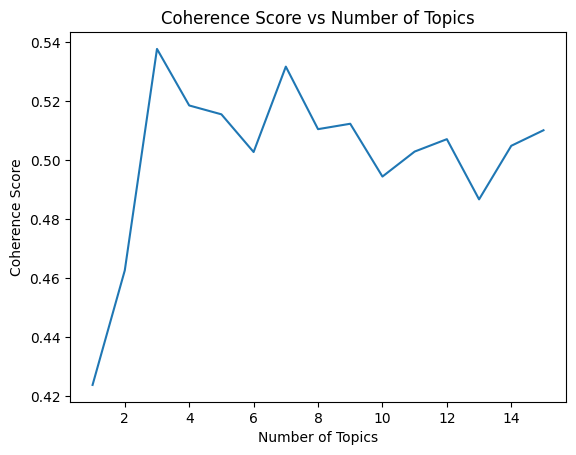

Optimal number of topics: 3


In [31]:

# Compute Coherence Scores for different number of topics
coherence_scores = []
num_topics_list = range(1, 16)  # Test different numbers of topics
for num_topics in num_topics_list:
    lda_model = LdaModel(corpus=corpus,
                         id2word=id2word,
                         num_topics=num_topics,
                         random_state=42,
                         update_every=1,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=tokenized_text,
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_score)

# Plotting the coherence scores
plt.plot(num_topics_list, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Number of Topics")
plt.show()

# Select the number of topics with maximum coherence score
optimal_num_topics = num_topics_list[np.argmax(coherence_scores)]
print("Optimal number of topics:", optimal_num_topics)


In [32]:
# Tokenize the text data
tokenized_text = [list(set(simple_preprocess(doc)).intersection(test.technical_terms)) for doc in newdf['features']]

# Create a Gensim dictionary object
id2word = Dictionary(tokenized_text)

# Filter out extremes
# id2word.filter_extremes(no_above=0.5)

# Convert tokenized text to bag of words format
corpus = [id2word.doc2bow(text) for text in tokenized_text]

# corpus = list(set(corpus).intersection(technical_terms))

num_topics = 3
ldamodel = LdaModel(corpus=corpus,id2word=id2word,num_topics=num_topics,random_state=42,update_every=1,passes=20,alpha='auto',per_word_topics=True)

# Get the topics
topics = ldamodel.show_topics(num_topics=num_topics, num_words=10, log=False, formatted=False)

# Print the topics
for topic_id, topic in topics:
    print("Topic: {}".format(topic_id))
    print("Words: {}".format([word for word, _ in topic]))

Topic: 0
Words: ['neural_network', 'queue', 'bert', 'hypothesis', 'clustering', 'lda', 'mining', 'data', 'scala', 'emacs']
Topic: 1
Words: ['python', 'queue', 'rest', 'html', 'notion', 'robotics', 'cs', 'http', 'xml', 'arduino']
Topic: 2
Words: ['programming', 'list', 'data', 'model', 'database', 'data_science', 'neural_network', 'express', 'variance', 'string']


WordCloud for LDA

In [33]:
def generate_wordcloud(topic_words, title):
    wordcloud = WordCloud(width = 500, height = 500,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(' '.join(topic_words))

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()


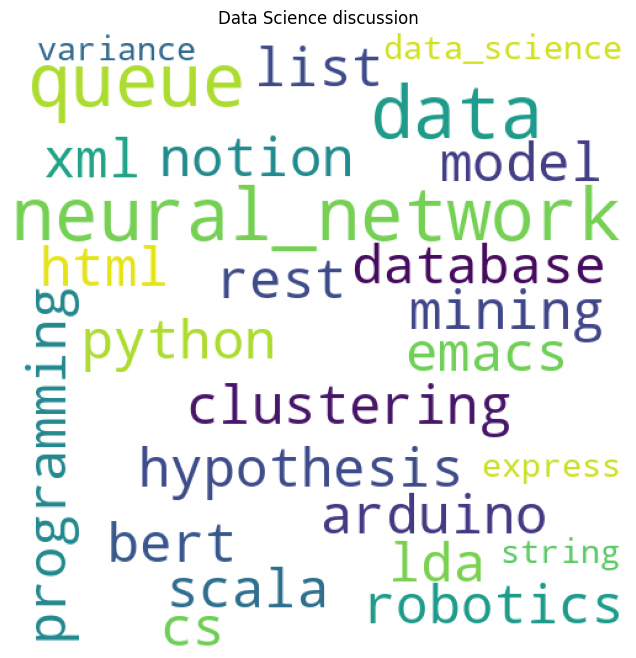

In [34]:
total_words = []
# # Generate word cloud for each topic
for i, topic_words in enumerate(topics):
    total_words += [word for word, _ in topic_words[1]]

generate_wordcloud(total_words,"Data Science discussion")


PREDICT DOCUMENTS USING LDA

In [35]:
# Get the topic distributions for the new documents
topic_distributions = [ldamodel[doc] for doc in corpus]
topic_distributions_list = []

#Print topic distributions for each document
for i, doc_topics in enumerate(topic_distributions):
    topic_distributions_list.append({  "Probability": doc_topics[2]})

# Create a DataFrame from the list of topic distributions
topic_distributions_df = pd.DataFrame(topic_distributions_list)

# Print the DataFrame
print(topic_distributions_df)

                                           Probability
0                              [(0, [(0, 0.9986921)])]
1    [(1, [(0, 0.9958016)]), (2, [(0, 0.22130762), ...
2    [(0, [(0, 0.9975845)]), (1, [(0, 0.9958634)]),...
3                                                   []
4                                                   []
..                                                 ...
555                            [(5, [(0, 0.9916901)])]
556  [(5, [(0, 0.7841688), (2, 0.21577671)]), (9, [...
557                           [(36, [(1, 0.9985057)])]
558                                                 []
559                            [(5, [(0, 0.9916908)])]

[560 rows x 1 columns]


In [36]:
joined_df = topic_distributions_df.join(newdf['features'])

LDA Allocation of Clusters to Documents

In [37]:
# Set display options to show all columns and wrap text
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)  # Prevent the DataFrame from being wrapped

# Print the DataFrame
print(joined_df)

                                           Probability                                           features
0                              [(0, [(0, 0.9986921)])]  site education site educator bert end soliciti...
1    [(1, [(0, 0.9958016)]), (2, [(0, 0.22130762), ...  used lot lately clustering generally yes lot s...
2    [(0, [(0, 0.9975845)]), (1, [(0, 0.9958634)]),...  notable difference question definitively eleme...
3                                                   []  best way question identify combination experie...
4                                                   []  c stack exchange use enable latex math stateme...
..                                                 ...                                                ...
555                            [(5, [(0, 0.9916901)])]  know advertising important source revenue stac...
556  [(5, [(0, 0.7841688), (2, 0.21577671)]), (9, [...  try write language table line break usually in...
557                           [(36, [(1, 0.998

In the output you provided, there are three parts:

The first part is a list of tuples representing the topic distribution for the document. Each tuple contains a topic ID (the first element) and the corresponding probability of that topic being present in the document (the second element).

The second part is a list of tuples representing the document's topic distribution in the form of a sparse matrix. Each tuple contains a topic ID and a list of topic weights associated with that document. In your example, it contains [(0, [5])], which indicates that the document is primarily associated with topic 5.

The third part is a list of tuples representing the topic distribution of the document in a different format. Each tuple contains a topic ID and its corresponding distribution in the document, represented as another tuple containing the topic ID and its probability. In your example, it contains [(0, [(5, 0.9999988)])], which indicates that topic 5 is highly dominant in the document, with a probability close to 1.

BERTOPIC ( TOPIC MODELING FOR POST1)

In [38]:
tokenized_text = [" ".join(list(set(simple_preprocess(doc)).intersection(test.technical_terms))) for doc in newdf['features']]

# Create a new dataframe with tokenized text as a column
tokenized_df = pd.DataFrame(tokenized_text, columns=["tokenized_text"])

In [39]:
from bertopic import BERTopic

In [40]:
topic_model = BERTopic()
topics,props = topic_model.fit_transform(tokenized_df["tokenized_text"])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [41]:
tm_info = topic_model.get_topic_info()

In [42]:
tm_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,8,-1_html_xml_bootstrap_agile,"[html, xml, bootstrap, agile, azure, kubernete...","[cs html, xml html, html]"
1,0,382,0_cookie___,"[cookie, , , , , , , , , ]","[, , cookie]"
2,1,32,1_neuralnetwork_model_scala_mining,"[neuralnetwork, model, scala, mining, github, ...",[string aws pytorch model tensorflow zoom neur...
3,2,30,2_database_datascience_data_programming,"[database, datascience, data, programming, cor...","[database programming, database programming, d..."
4,3,29,3_python_bert_rest_lda,"[python, bert, rest, lda, clustering, notion, ...","[python, python, rest programming python]"
5,4,28,4_list_iterators_express_data,"[list, iterators, express, data, python, , , ,...","[list, list, list]"
6,5,26,5_programming_sketch_mutex_arduino,"[programming, sketch, mutex, arduino, unix, ro...","[programming, programming, programming]"
7,6,13,6_queue_neuralnetwork_matlab_jquery,"[queue, neuralnetwork, matlab, jquery, unstruc...","[queue, queue, queue neural_network]"
8,7,12,7_model_hypothesis_atom_data,"[model, hypothesis, atom, data, programming, ,...","[model, model, model]"


In [43]:
# Visualize hierarchical topic clusters
topic_model.visualize_hierarchy()


In [44]:
topic_model.visualize_barchart(top_n_topics=10)

In [45]:
topics_assigned = topic_model.transform(tokenized_df["tokenized_text"])

In [46]:
len(topics_assigned[0])
topicBertdf = pd.DataFrame(topics_assigned[0], columns=['Cluster_assigned'])

In [47]:
joined_df = tokenized_df.join(topicBertdf)

In [48]:
joined_df

,tokenized_text,Cluster_assigned
0,bert,3
1,list mining neural_network clustering data,1
2,bert lda clustering programming data,3
3,,0
4,,0
...,...,...
555,neural_network,1
556,string aws pytorch model tensorflow zoom neura...,1
557,html,-1
558,,0
